# Collaboration and Competition

## 1. Start the Environment

In [1]:
import gym
import numpy as np
import random
import torch
import time # for perf count

from collections import deque
from unityagents import UnityEnvironment
import matplotlib.pyplot as plt
%matplotlib inline

Next, we will start the environment! Before running the code cell below, change the file_name parameter to match the location of the Unity environment that you downloaded.

- Mac: "path/to/Tennis.app"
- Windows (x86): "path/to/Tennis_Windows_x86/Tennis.exe"
- Windows (x86_64): "path/to/Tennis_Windows_x86_64/Tennis.exe"
- Linux (x86): "path/to/Tennis_Linux/Tennis.x86"
- Linux (x86_64): "path/to/Tennis_Linux/Tennis.x86_64"
- Linux (x86, headless): "path/to/Tennis_Linux_NoVis/Tennis.x86"
- Linux (x86_64, headless): "path/to/Tennis_Linux_NoVis/Tennis.x86_64"

For instance, if you are using a Mac, then you downloaded Tennis.app. If this file is in the same folder as the notebook, then the line below should appear as follows:

env = UnityEnvironment(file_name="Tennis.app")

In [2]:
env = UnityEnvironment(file_name="unity_env/Tennis.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain brains which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

## 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1. If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01. Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping.

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])
print('States shape:', states.shape)

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]
States shape: (2, 24)


## 3. Train Agents with MADDPG

### 3.1 Instantiate Agents

In [5]:
from maddpg_agent import MADDPG

random_seed = 12

#### 3.1.2 Create Agents

In [6]:
agent = MADDPG(state_size, action_size, random_seed, num_agents)

In [7]:
def maddpg(n_episodes=2000, max_t=10000):
    scores_deque = deque(maxlen=100)
    scores = []
    max_score = -np.Inf
    for i_episode in range(1, n_episodes+1):
        start_time = time.perf_counter()
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        agent.reset()
        episode_scores = np.zeros(num_agents)
        for t in range(max_t):
            actions = agent.act(states)
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done
            
            agent.step(states, actions, rewards, next_states, dones)
            
            states = next_states
            episode_scores += rewards
            if np.any(dones):
                break 
        score = max(episode_scores)
        scores_deque.append(score)
        scores.append(score)
        end_time = time.perf_counter()
        print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.2f} \tTime/Episode: {:.2f}'.format(i_episode, np.mean(scores_deque), score, (end_time - start_time)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f} \tTime/Episode: {:.2f}'.format(i_episode, np.mean(scores_deque), (end_time - start_time)))
            
        if np.mean(scores_deque) >= 0.5:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_deque)))
            actor_state_dict = agent.actor_state_dict()
            for i in range(num_agents):
                torch.save(actor_state_dict[i], 'checkpoint_actor' + str(i) + '.pth')
            break
    return scores

Episode 100	Average Score: 0.01 	Time/Episode: 0.22pisode: 0.22
Episode 200	Average Score: 0.02 	Time/Episode: 0.22pisode: 0.22
Episode 300	Average Score: 0.02 	Time/Episode: 0.22pisode: 0.22
Episode 400	Average Score: 0.03 	Time/Episode: 0.23pisode: 0.23
Episode 500	Average Score: 0.05 	Time/Episode: 0.47pisode: 0.47
Episode 600	Average Score: 0.07 	Time/Episode: 0.48pisode: 0.48
Episode 700	Average Score: 0.09 	Time/Episode: 0.47pisode: 0.47
Episode 800	Average Score: 0.14 	Time/Episode: 0.47pisode: 0.47
Episode 900	Average Score: 0.19 	Time/Episode: 3.45pisode: 3.45
Episode 998	Average Score: 0.52	Score: 2.60 	Time/Episode: 15.58
Environment solved in 898 episodes!	Average Score: 0.52


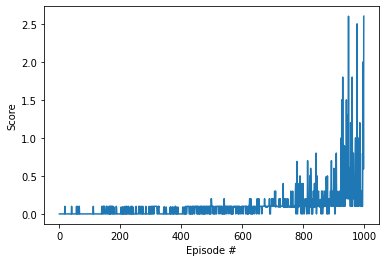

In [8]:
scores = maddpg(2000)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

## 4. Watch Smart Agents

In [9]:
actor_state_dict_list = [torch.load('checkpoint_actor' + str(i) + '.pth') for i in range(num_agents)]
agent.load_actor_state_dict(actor_state_dict_list)

for i in range(1, 6):
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    score = np.zeros(num_agents)                           # initialize the score (for each agent)
    while True:
        actions = agent.act(states)                        # select an action (for each agent)
        #action = np.clip(action, -1, 1)                   # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        score += env_info.rewards                          # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (max-ed over agents) this episode: {}'.format(max(score)))

Total score (max-ed over agents) this episode: 2.7000000402331352
Total score (max-ed over agents) this episode: 0.0
Total score (max-ed over agents) this episode: 2.600000038743019
Total score (max-ed over agents) this episode: 1.4000000208616257
Total score (max-ed over agents) this episode: 2.600000038743019


## 5. Cleanup

When finished, you can close the environment.

In [10]:
env.close()